In [17]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [48]:
stocks = yf.download(['AAPL', 'MSFT'], period='1y')['Adj Close']

[*********************100%***********************]  2 of 2 completed


In [49]:
stocks

,AAPL,MSFT
Date,,
2019-09-05,52.796162,138.473541
2019-09-06,52.791210,137.534241
2019-09-09,53.016479,135.972031
2019-09-10,53.642761,134.548248
2019-09-11,55.348343,134.587753
...,...,...
2020-08-31,129.039993,225.529999
2020-09-01,134.179993,227.270004
2020-09-02,131.399994,231.649994


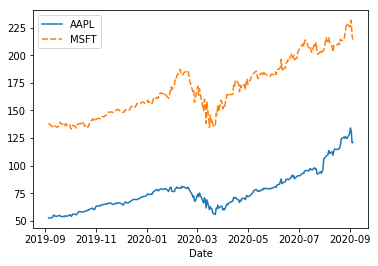

In [56]:
sns.lineplot(data=stocks)